# ITCS 3162 Final Group Project

In [1]:
#Import necessary tools
#DF Imports
import pandas as pd
import numpy as np

#Viz imports
import matplotlib.pyplot as plt
import seaborn as sns


#Modeling imports
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB, ComplementNB
from scipy import stats
from sklearn.svm import LinearSVC
import re
import random
from scipy import stats
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#Eval imports
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, mean_squared_error, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score


print("Setup Complete!")

Setup Complete!


## Import data

In [2]:
#Import training data for exploration

df = pd.read_csv('train.csv')

In [3]:
#Look at the shape
df.shape

(891, 12)

In [4]:
#Take a look at the head to get a feel for the data
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#Some of the column names are a little bit confusing so let's see if we can get a little bit more clarity
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Pre-processing

In [6]:
#Let's start by looking for NA values
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We'll need to either drop some observations that have N/A values for age or impute values. Given that we don't have a very high number of observations to begin with it probably makes sense to impute mean values where data is missing. 

In [7]:
#Fill our NA garage area variable with the mean for the feature
df['Age'].fillna(df['Age'].mean(), inplace = True)

In [8]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are some pretty substantial amounts of NA data. we'll need to look for any underlying causes and either impute missing data or drop observations. Specifically, missing cabin data and home destination could have meaningful impacts on the ability to predict survival or death.

In [9]:
#Check for duplicated observations 
df.duplicated().value_counts()

False    891
dtype: int64

In [10]:
#Check data types for each feature
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

* Note to consider whether any of the quantitative data types work better as categorical binned features and convert in alt df if useful 
* Note to revisit looking for outliers after checking for them during EDA

## Exploratory Data Analysis and Visualization

### Survival

In [11]:
#Let's start off by trying to understand our target a little bit better
df.Survived.describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

It looks like the target variable is a binary 0/1. Documentation notes that 0 indicates death and 1 indicates survival. We should probably consider changing this to a standardized 'Yes' or 'No' String to make it a little bit clearer for users reading our code.

In [12]:
#Create a function to convert 0/1 survival indicators to yes no for ease of comprehension
def survived_to_string(row):
    if (row['Survived'] == 0):
        return 'no'
    if (row['Survived'] == 1):
        return 'yes'

In [13]:
#Apply the function that we've created to create a new column
df['Survived_txt'] = df.apply(lambda row: survived_to_string(row), axis = 1)

In [14]:
#Let's double check that our column appears with the expected results
df['Survived_txt'].value_counts()

no     549
yes    342
Name: Survived_txt, dtype: int64

In [15]:
#Check to make sure that the original 'Survived' column remains in numerical form
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [16]:
df['Survived'].value_counts(normalize = True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Let's start by  looking at the raw distribution of survival outcomes. We'll circle back and look at survival in combination with different features down the road but we'll start with a simple viz.

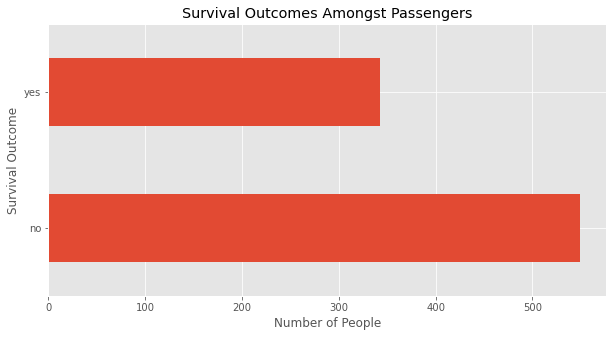

In [17]:
#Create a bar graph visualization of survival
plt.figure(figsize = (10,5))
plt.style.use('ggplot')

df.groupby('Survived_txt').size().plot(kind = 'barh').set(title = 'Survival Outcomes Amongst Passengers', 
                                                          xlabel = 'Number of People', ylabel = 'Survival Outcome')
plt.savefig('surival.png', bbox_inches = 'tight')

### Passenger Class and Fare

In [18]:
df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

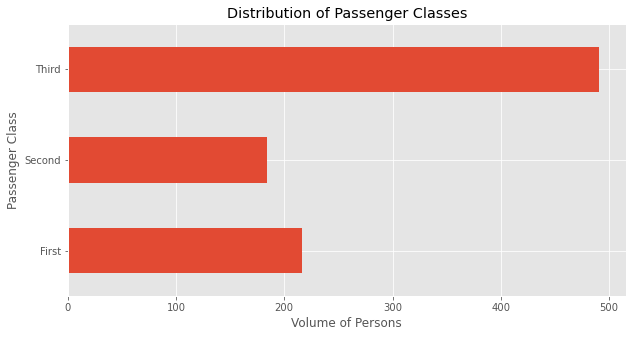

In [19]:
#Now let's look at the distribution of passenger classes
plt.figure(figsize = (10,5))
plt.style.use('ggplot')

df.groupby('Pclass').size().plot(kind = 'barh').set(title = 'Distribution of Passenger Classes', 
                                                          xlabel = 'Volume of Persons', ylabel = 'Passenger Class',
                                                   yticklabels = 
                                                    ['First', 'Second', 'Third'])
plt.show()
#plt.savefig('surival.png', bbox_inches = 'tight')

In [20]:
#Let's look at summary statistics for fare
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [21]:
df['Fare'].median()

14.4542

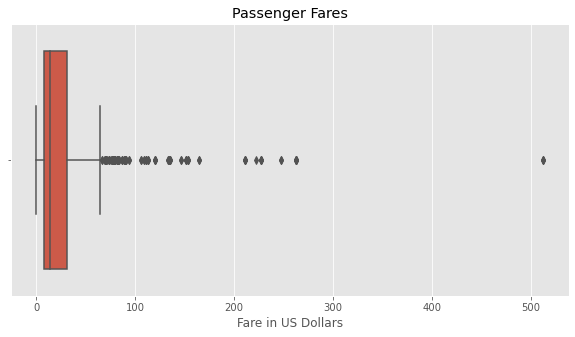

In [22]:
#Visualize the distribution of fare price
plt.figure(figsize = (10,5))
plt.style.use('ggplot')

ax = sns.boxplot(x = 'Fare', data = df)
ax.set(title = 'Passenger Fares', xlabel = 'Fare in US Dollars' )
#plt.show()
plt.savefig('fare.png', bbox_inches = 'tight')

[Text(0.5, 1.0, 'Passenger Fares'), Text(0.5, 0, 'Fare in US Dollars')]

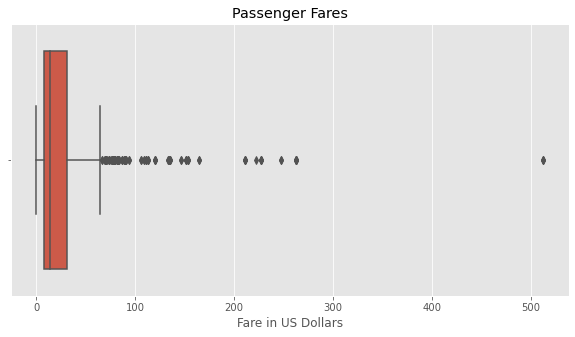

In [23]:
#Visualize the log of distribution of fare price
plt.figure(figsize = (10,5))
plt.style.use('ggplot')

ax = sns.boxplot(x = 'Fare', data = df)
ax.set(title = 'Passenger Fares', xlabel = 'Fare in US Dollars' )
#plt.show()
#plt.savefig('SalePriceDist.png', bbox_inches = 'tight')

It looks like there are some substantial outliers and that we'll need to transform this data a bit if we're going to use it in models. Make note of this for later.

### General Demographics

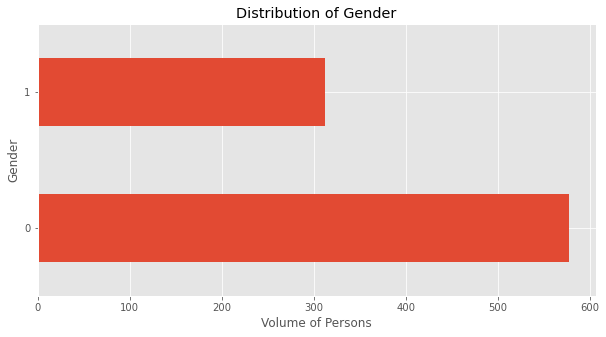

In [71]:
#Let's look at the distribution of men and women
plt.figure(figsize = (10,5))
plt.style.use('ggplot')

df.groupby('Sex').size().plot(kind = 'barh').set(title = 'Distribution of Gender', 
                                                          xlabel = 'Volume of Persons', ylabel = 'Gender')
#plt.show()
plt.savefig('gender.png', bbox_inches = 'tight')

In [25]:
df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [73]:
df['Sex'].value_counts(normalize = True)

0    0.649044
1    0.350956
Name: Sex, dtype: float64

In [26]:
#And now age
df['Age'].describe()

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [27]:
df['Age'].median()

29.69911764705882

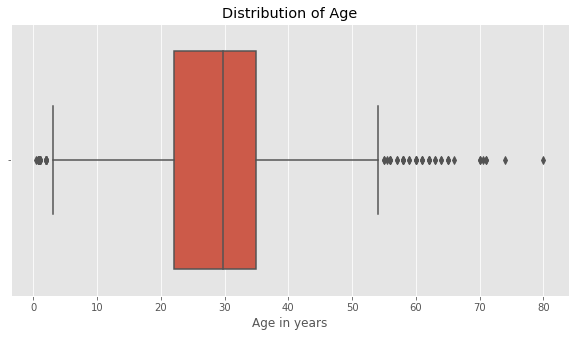

In [28]:
#Visualize the distribution of sale price
plt.figure(figsize = (10,5))
plt.style.use('ggplot')

ax = sns.boxplot(x = 'Age', data = df)
ax.set(title = 'Distribution of Age', xlabel = 'Age in years' )
#plt.show()
plt.savefig('age.png', bbox_inches = 'tight')

One interesting note from the code book is that estimated ages are recored in the form of xx.5. It may be interesting to consider whether a passenger's age is known or not using a modulo.

In [29]:
#Next we'll look at the amount of family that passengers had onboard. We'll start with siblings
df['SibSp'].describe()

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

In [30]:
df['SibSp'].median()

0.0

In [31]:
df['Parch'].describe()

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

#Let's create a binary categorical feature that indicates whether a given passenger has family on the boat or not. 0 will indicate that a passenger does NOT have family present, while 1 will indicate that a passenger DOES have family present.

In [32]:
#Create a function to indicate the present of family
def family(row):
    if (row['SibSp'] > 0):
        return 1
    elif (row['Parch'] > 0):
        return 1
    else:
        return 0

In [33]:
#Apply the function that we've created to create a new column
df['Family'] = df.apply(lambda row: family(row), axis = 1)

In [34]:
#Visually inspect to make sure that new feature is working as intended
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived_txt,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,no,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,yes,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,yes,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,yes,1
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,no,0
5,6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q,no,0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S,no,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S,no,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,NaN,S,yes,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,NaN,C,yes,1


In [35]:
df['Family'].value_counts(normalize = True)

0    0.602694
1    0.397306
Name: Family, dtype: float64

About 60% of travelers had no spouse or relations on board while ~39.7% were traveling with a spouse or relative

### Point of Origin

In [36]:
#Now let's look at where various passengers began their journey
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [37]:
df['Embarked'].value_counts(normalize = True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

### Relationship between Variables and Survival Outcome

Now that we've explored the features a little bit, let's look at how they relate to survival

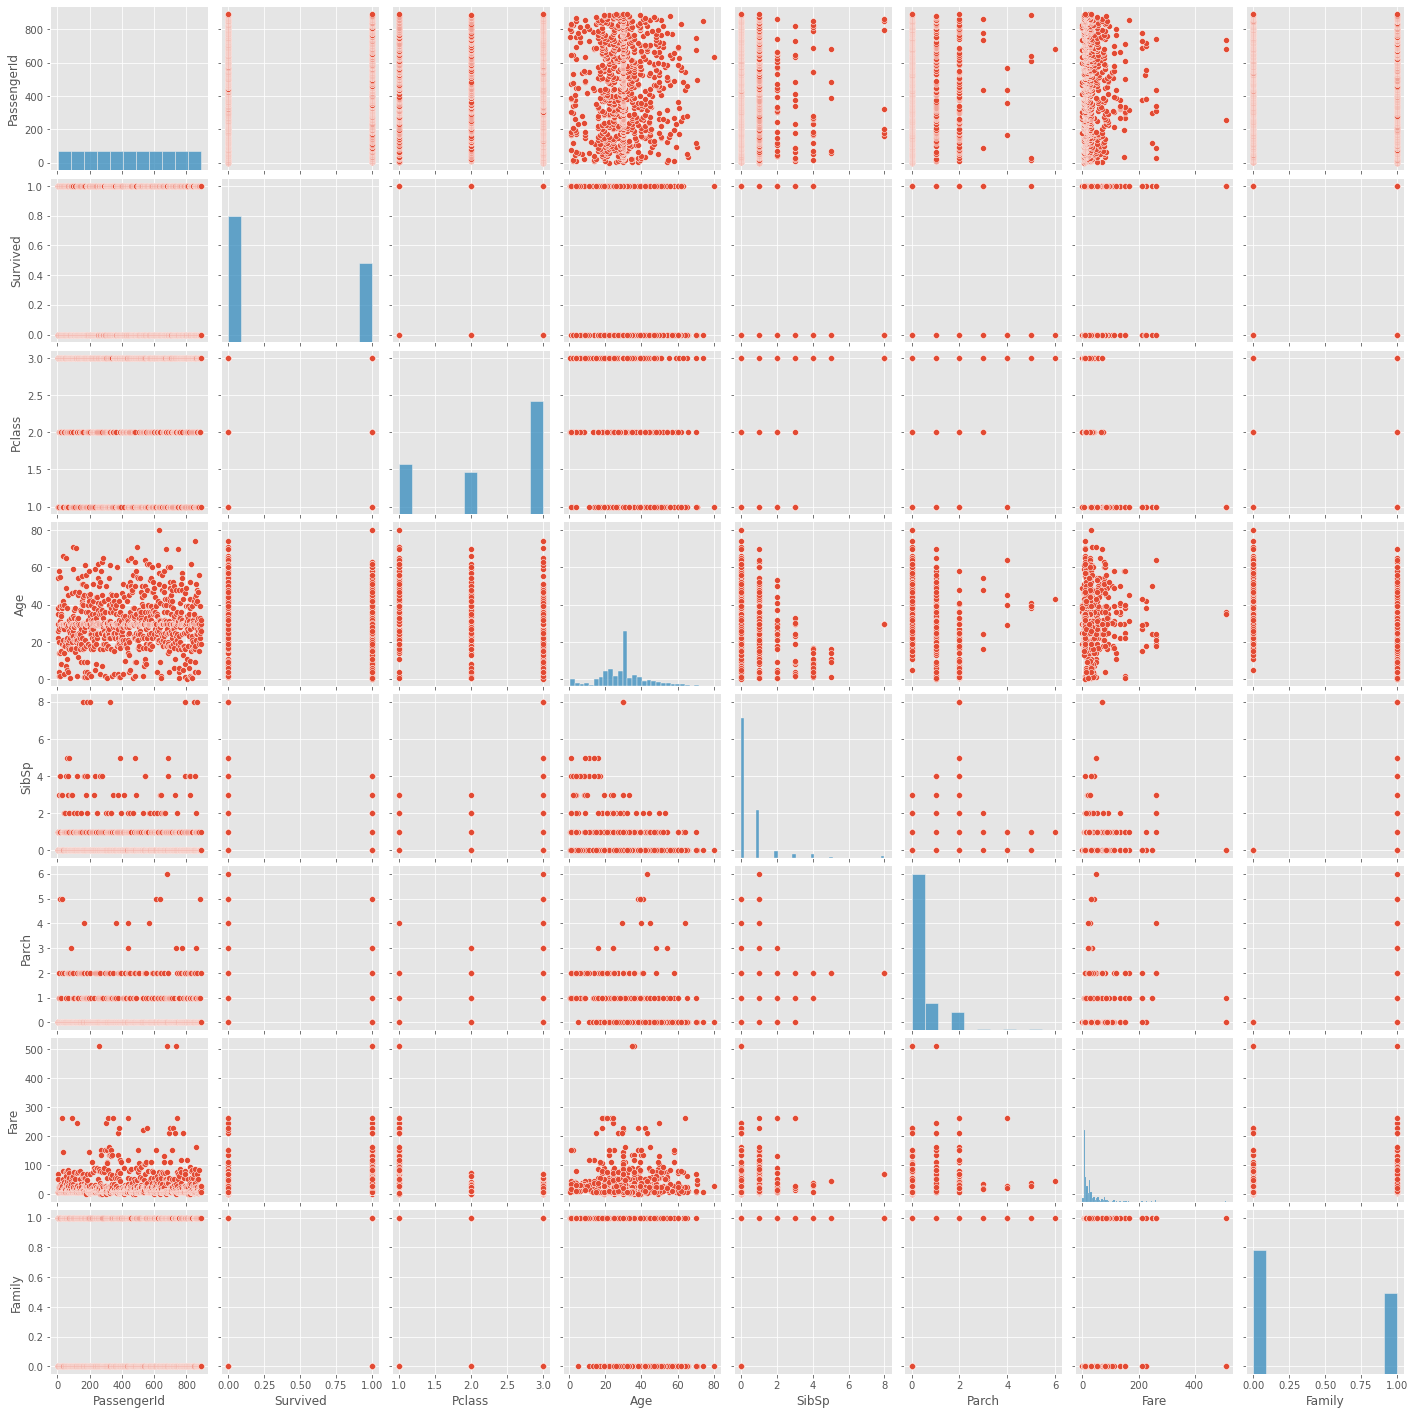

In [38]:
sns.pairplot(df)

This pair plot is a little bit difficult to make sense of because most of the quantitative variables are binary rather than continuous. However, it does give us a few places to do some additional zooming in to look for evidence of a relationship.

Specifically, let's take a look at the relationships between age, fare, family and survival.

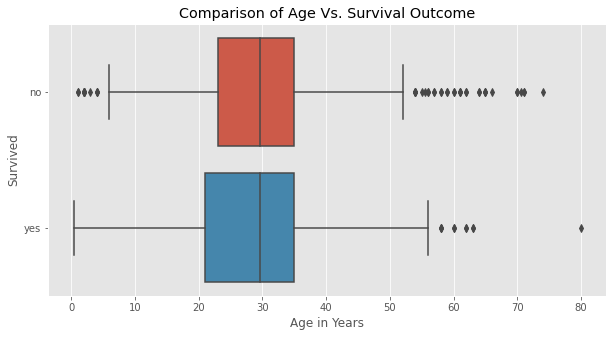

In [39]:
#Visualize the age of survivors
plt.figure(figsize = (10,5))
plt.style.use('ggplot')
ax = sns.boxplot(x = 'Age', y = 'Survived_txt', data = df)
ax.set(title = 'Comparison of Age Vs. Survival Outcome', xlabel = 'Age in Years',
      ylabel = 'Survived')
#plt.show()
plt.savefig('age_vs_survival', bbox_inches = 'tight')

In [74]:
df['Fare'].describe()

count    889.000000
mean      32.096681
std       49.697504
min        0.000000
25%        7.895800
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [75]:
df['Fare'].median()

14.4542

In [76]:
df['Pclass'].value_counts()

3    491
1    214
2    184
Name: Pclass, dtype: int64

In [77]:
df['Pclass'].value_counts(normalize = True)

3    0.552306
1    0.240720
2    0.206974
Name: Pclass, dtype: float64

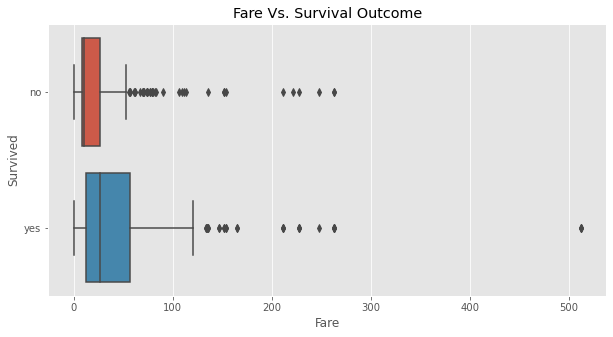

In [40]:
#Visualize the fare rate of survivors
plt.figure(figsize = (10,5))
plt.style.use('ggplot')
ax = sns.boxplot(x = 'Fare', y = 'Survived_txt', data = df)
ax.set(title = 'Fare Vs. Survival Outcome', xlabel = 'Fare',
      ylabel = 'Survived')
plt.show()
#plt.savefig('fare_vs_survival', bbox_inches = 'tight')

It looks like this graph is definitely trying to tell us something but the output could probably be more useful if we normalized the data to reduce the impact of outliers. Let's try this by taking the log of fares rather than using them directly.

/Users/johntate/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


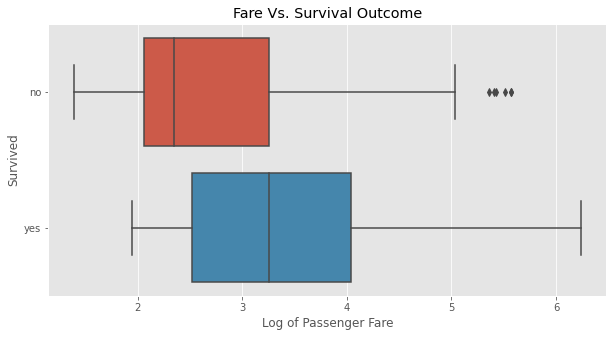

In [41]:
#Visualize the fare rate of survivors
plt.figure(figsize = (10,5))
plt.style.use('ggplot')
ax = sns.boxplot(x = np.log(df['Fare']), y = 'Survived_txt', data = df)
ax.set(title = 'Fare Vs. Survival Outcome', xlabel = 'Log of Passenger Fare',
      ylabel = 'Survived')
#plt.show()
plt.savefig('fare_vs_survival_normalized', bbox_inches = 'tight')

Much clearer, we can definitely see that surviving passengers paid a higher fare on average. Let's move on to family.

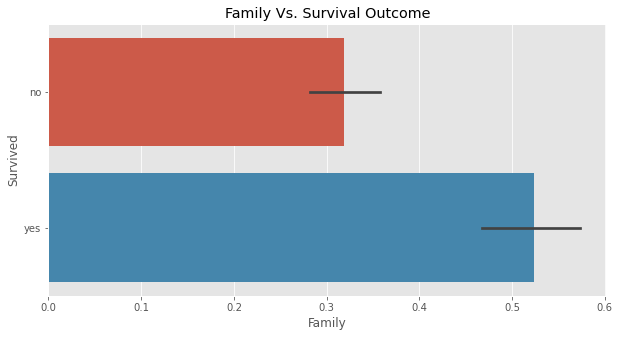

In [42]:
#Visualize the family status of survivors
plt.figure(figsize = (10,5))
plt.style.use('ggplot')
ax = sns.barplot(x = 'Family', y = 'Survived_txt', data = df)
ax.set(title = 'Family Vs. Survival Outcome', xlabel = 'Family',
      ylabel = 'Survived')
#plt.show()
plt.savefig('family_vs_survival', bbox_inches = 'tight')

In summary, when we look at age, fare, and family it seems that all three have an effect on survival outcomes:
- Younger passengers were more likely to surive
- Those who paid a higher fare were more likely to survive when compared to those that paid a lower fare.
- Having family onboard increases the likelihood of survival.

Finally, now that we've added some features and made some modifications to the data let's export the CSV to make sure that the whole team is working off of the same data set.

In [43]:
final_titanic_data = df.to_csv('final_titanic_data.csv', index = False)

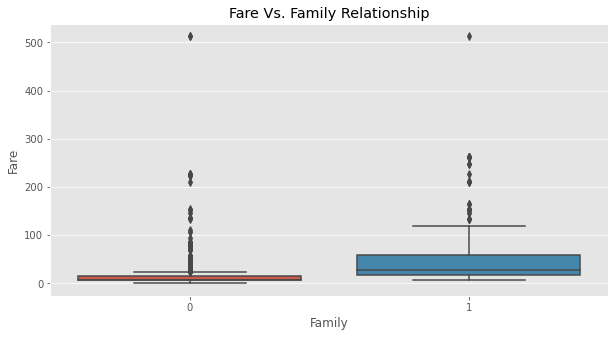

In [81]:
#Visualize the fare rate of survivors
plt.figure(figsize = (10,5))
plt.style.use('ggplot')
ax = sns.boxplot(x = 'Family', y = 'Fare', data = df)
ax.set(title = 'Fare Vs. Family Relationship', xlabel = 'Family',
      ylabel = 'Fare')
#plt.show()
plt.savefig('fare_vs_family', bbox_inches = 'tight')

# Modeling

Now that we've explored our data and modified it where appropriate let's begin the modeling process. Our intended models include:
- Decision Trees
- Random Forest
- Logistic Regression

We'll start with a pretty sparse model for each one and get a feeling for which performs the best and then do some feature engineering. However, let's start by checking the baseline.

In [44]:
df['Survived'].value_counts(normalize = True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Our basline for raw accuracy is ~61.61%

### Second round of pre-processing to assist in modeling

Next we'll need to transform some of our string variables into numerical variables so that our models can work with them.

In [45]:
#Transform male and female strings to 0 and 1 respectively
df = df.replace('male', 0)
df = df.replace('female', 1)

In [46]:
#Transform 'Embarked' data so that 0 represents S, 1 represents C, and 2 represents Q
df['Embarked'] = df['Embarked'].replace('S', 0)
df['Embarked'] = df['Embarked'].replace('C', 1)
df['Embarked'] = df['Embarked'].replace('Q', 2)

In [47]:
#We still have some NA values hanging out even though we imputed the mean for our age variable. 
df.isna().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
Survived_txt      0
Family            0
dtype: int64

In [48]:
#Since we aren't using cabin we'll just drop the two observations that have missing values for embarked
df.dropna(axis=0, subset= ['Embarked'], inplace=True)

In [49]:
# Double check that we only dropped the two intended observations
df.shape

(889, 14)

In [50]:
#Create training and testing split at 70/30

train, test = train_test_split(df, test_size =0.3, random_state = 1888)

In [51]:
#Check our training columns for reference
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived_txt',
       'Family'],
      dtype='object')

In [52]:
#Check the data set to verify that no records are missing
print('DF shape:', df.shape)
print('Train shape: ',train.shape)
print('Test shape: ', test.shape)

DF shape: (889, 14)
Train shape:  (622, 14)
Test shape:  (267, 14)


It looks like everything worked with the split. All sets have the same number of features and the sum of observations in train and test is equal to the total DF.

In [53]:
#Set up our training sets. For the IVs we'll exclude passenger ID (irrelevant), and Sibling/Spouse Parent/Child (already folded into 'Family').
#For the dependent variable we'll use 'Survived'
x_train = train[['Pclass', 'Sex', 'Age', 'Fare','Family', 'Embarked']]
y_train = train['Survived']

In [54]:
#Set up our test sets to match.
x_test = test[['Pclass', 'Sex', 'Age', 'Fare','Family', 'Embarked']]
y_test = test['Survived']

## Decision Tree Modeling

In [55]:
#Create cart model using max 15 nodes
cart01 = tree.DecisionTreeClassifier(criterion = "gini", max_leaf_nodes=15).fit(x_train, y_train)

In [56]:
#Create our c50 model using max 15 nodes
c50_01 = tree.DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=15).fit(x_train,y_train)

In [57]:
y_pred_dt = cart01.predict(x_test)

In [58]:
print(confusion_matrix(y_test,y_pred_dt))
print(classification_report(y_test,y_pred_dt))
print(accuracy_score(y_test, y_pred_dt))

[[157   6]
 [ 36  68]]
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       163
           1       0.92      0.65      0.76       104

    accuracy                           0.84       267
   macro avg       0.87      0.81      0.82       267
weighted avg       0.85      0.84      0.84       267

0.8426966292134831


In [59]:
print("Training scores:")
print("CART: ", cart01.score(x_train, y_train))
print('C5.0 ', c50_01.score(x_train, y_train))
print("----------------")
print("Test scores:")
print("CART: ", cart01.score(x_test, y_test))
print('C5.0 ', c50_01.score(x_test, y_test))

Training scores:
CART:  0.8440514469453376
C5.0  0.837620578778135
----------------
Test scores:
CART:  0.8426966292134831
C5.0  0.8277153558052435


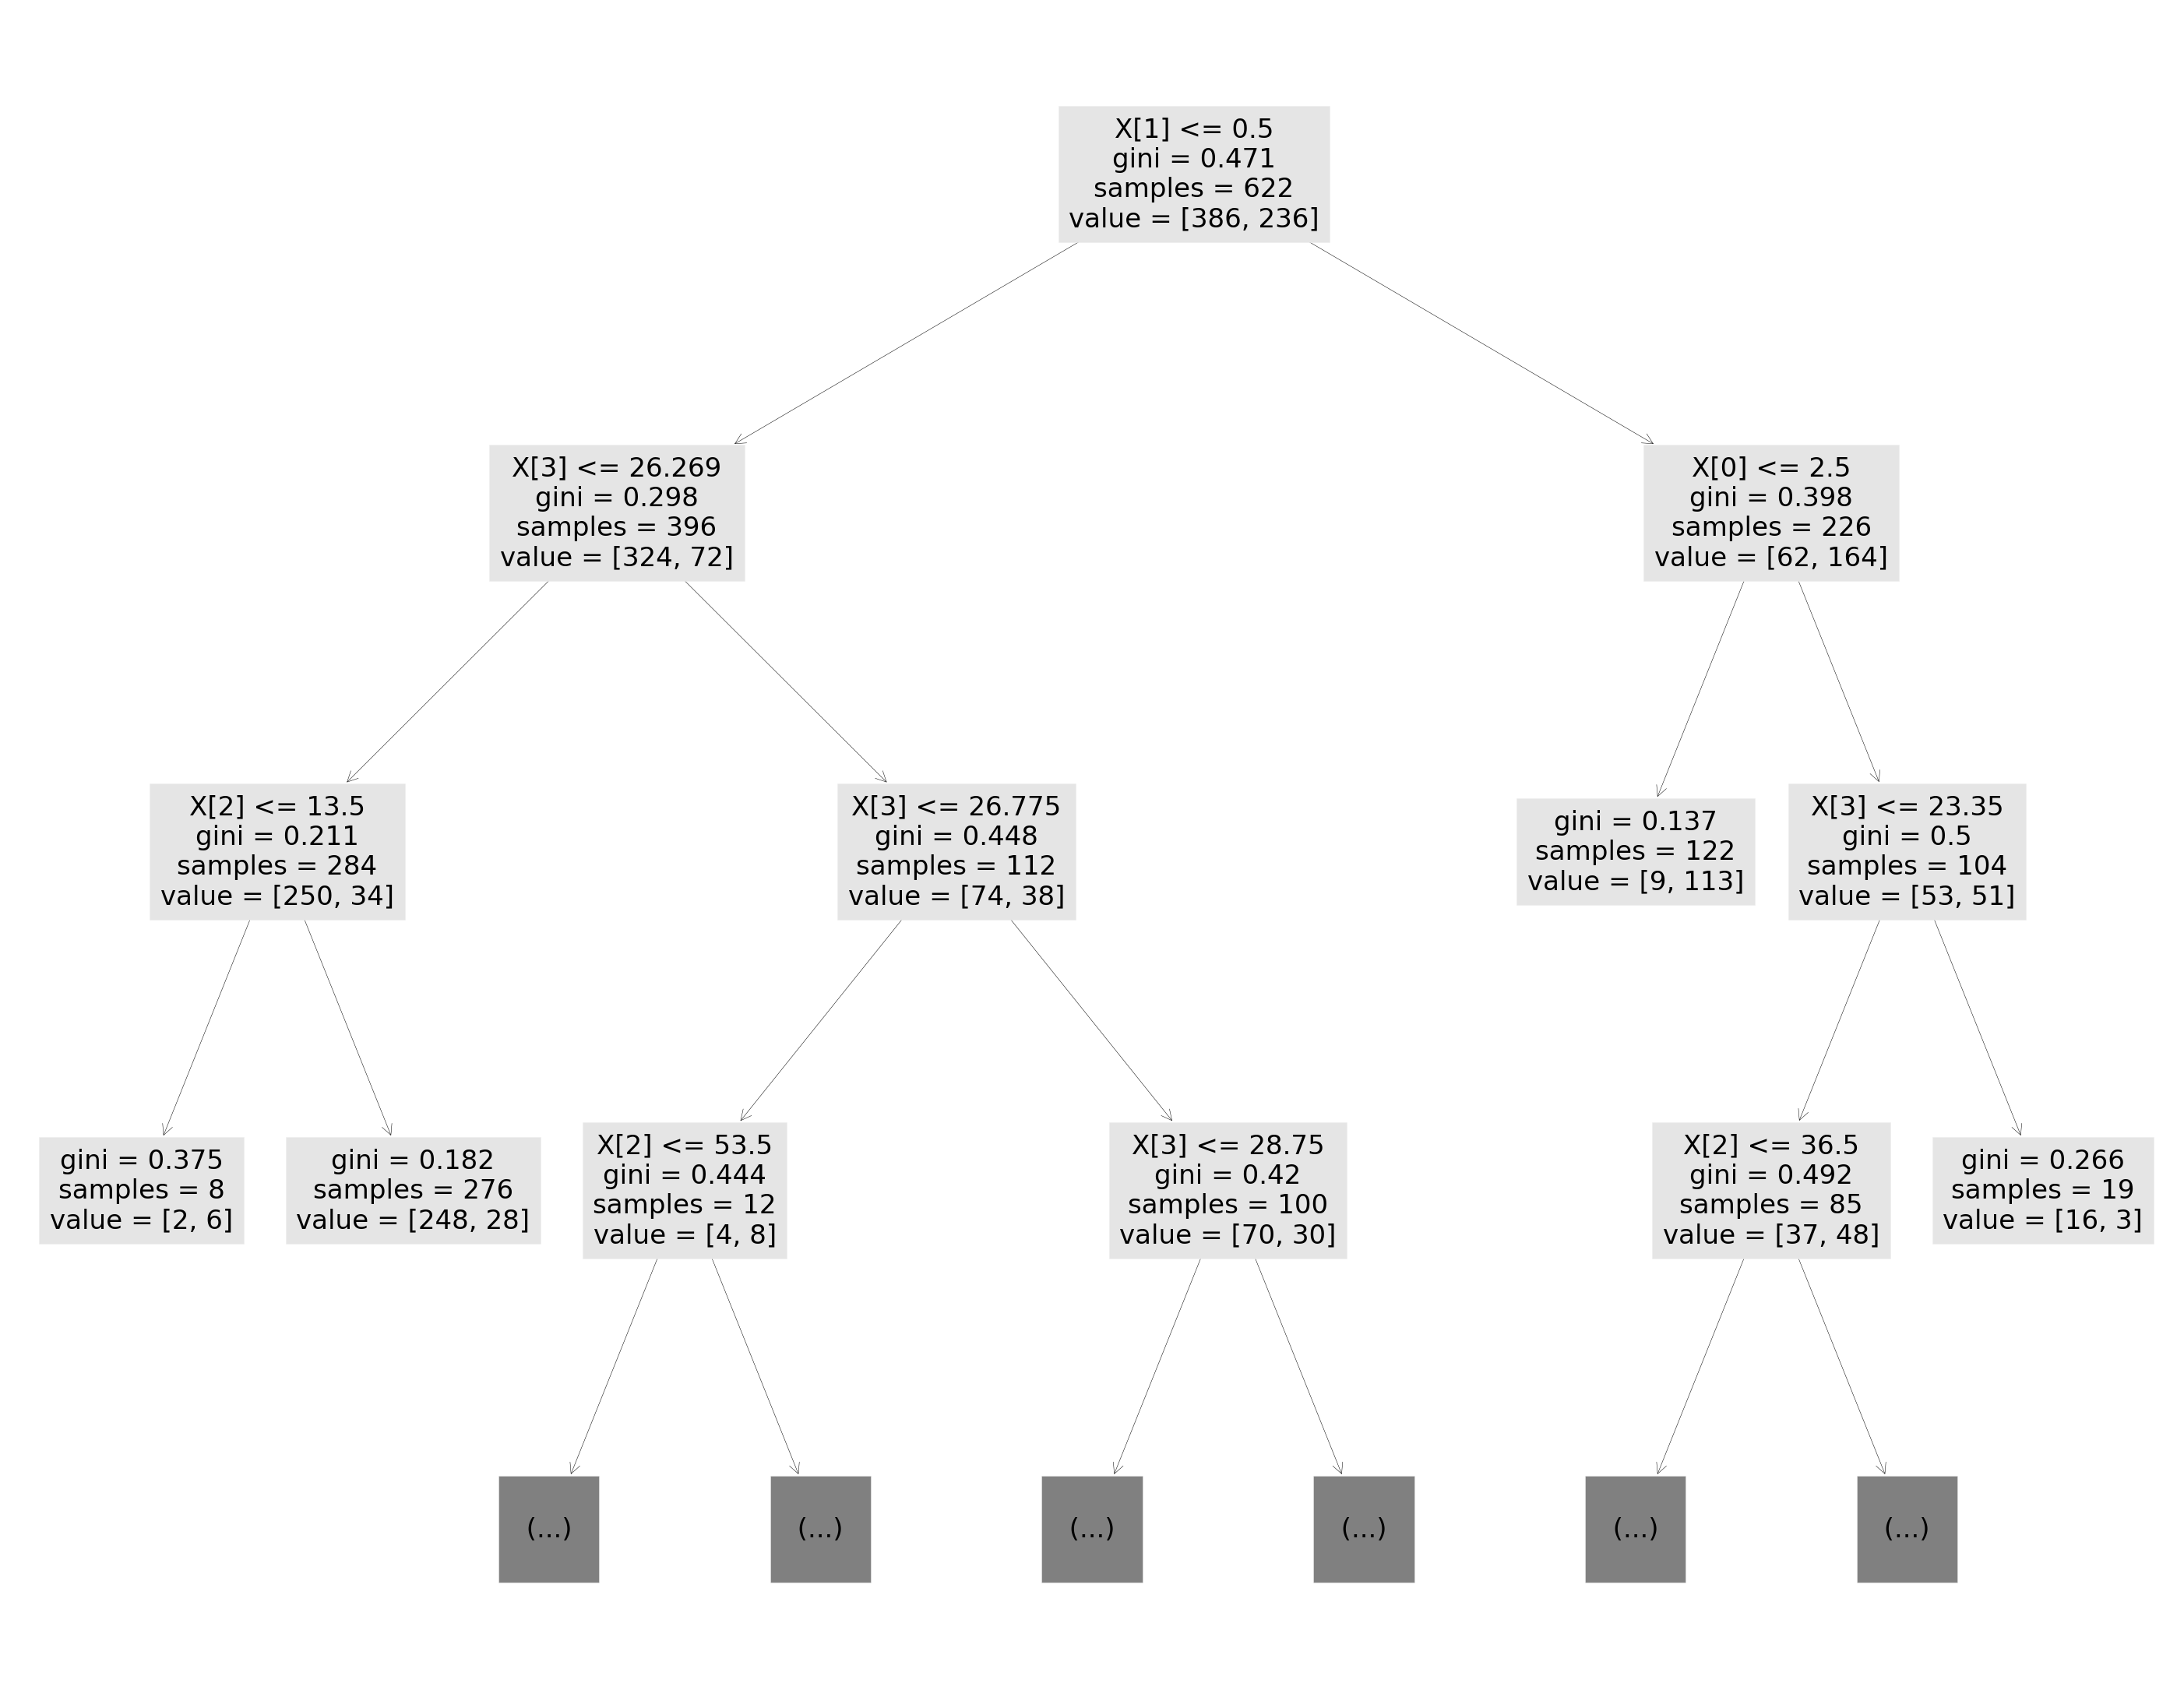

In [60]:
fig = plt.figure(figsize=(50,40))
tree.plot_tree(cart01, max_depth=3)
#plt.show()
plt.savefig('dt', bbox_inches = 'tight')

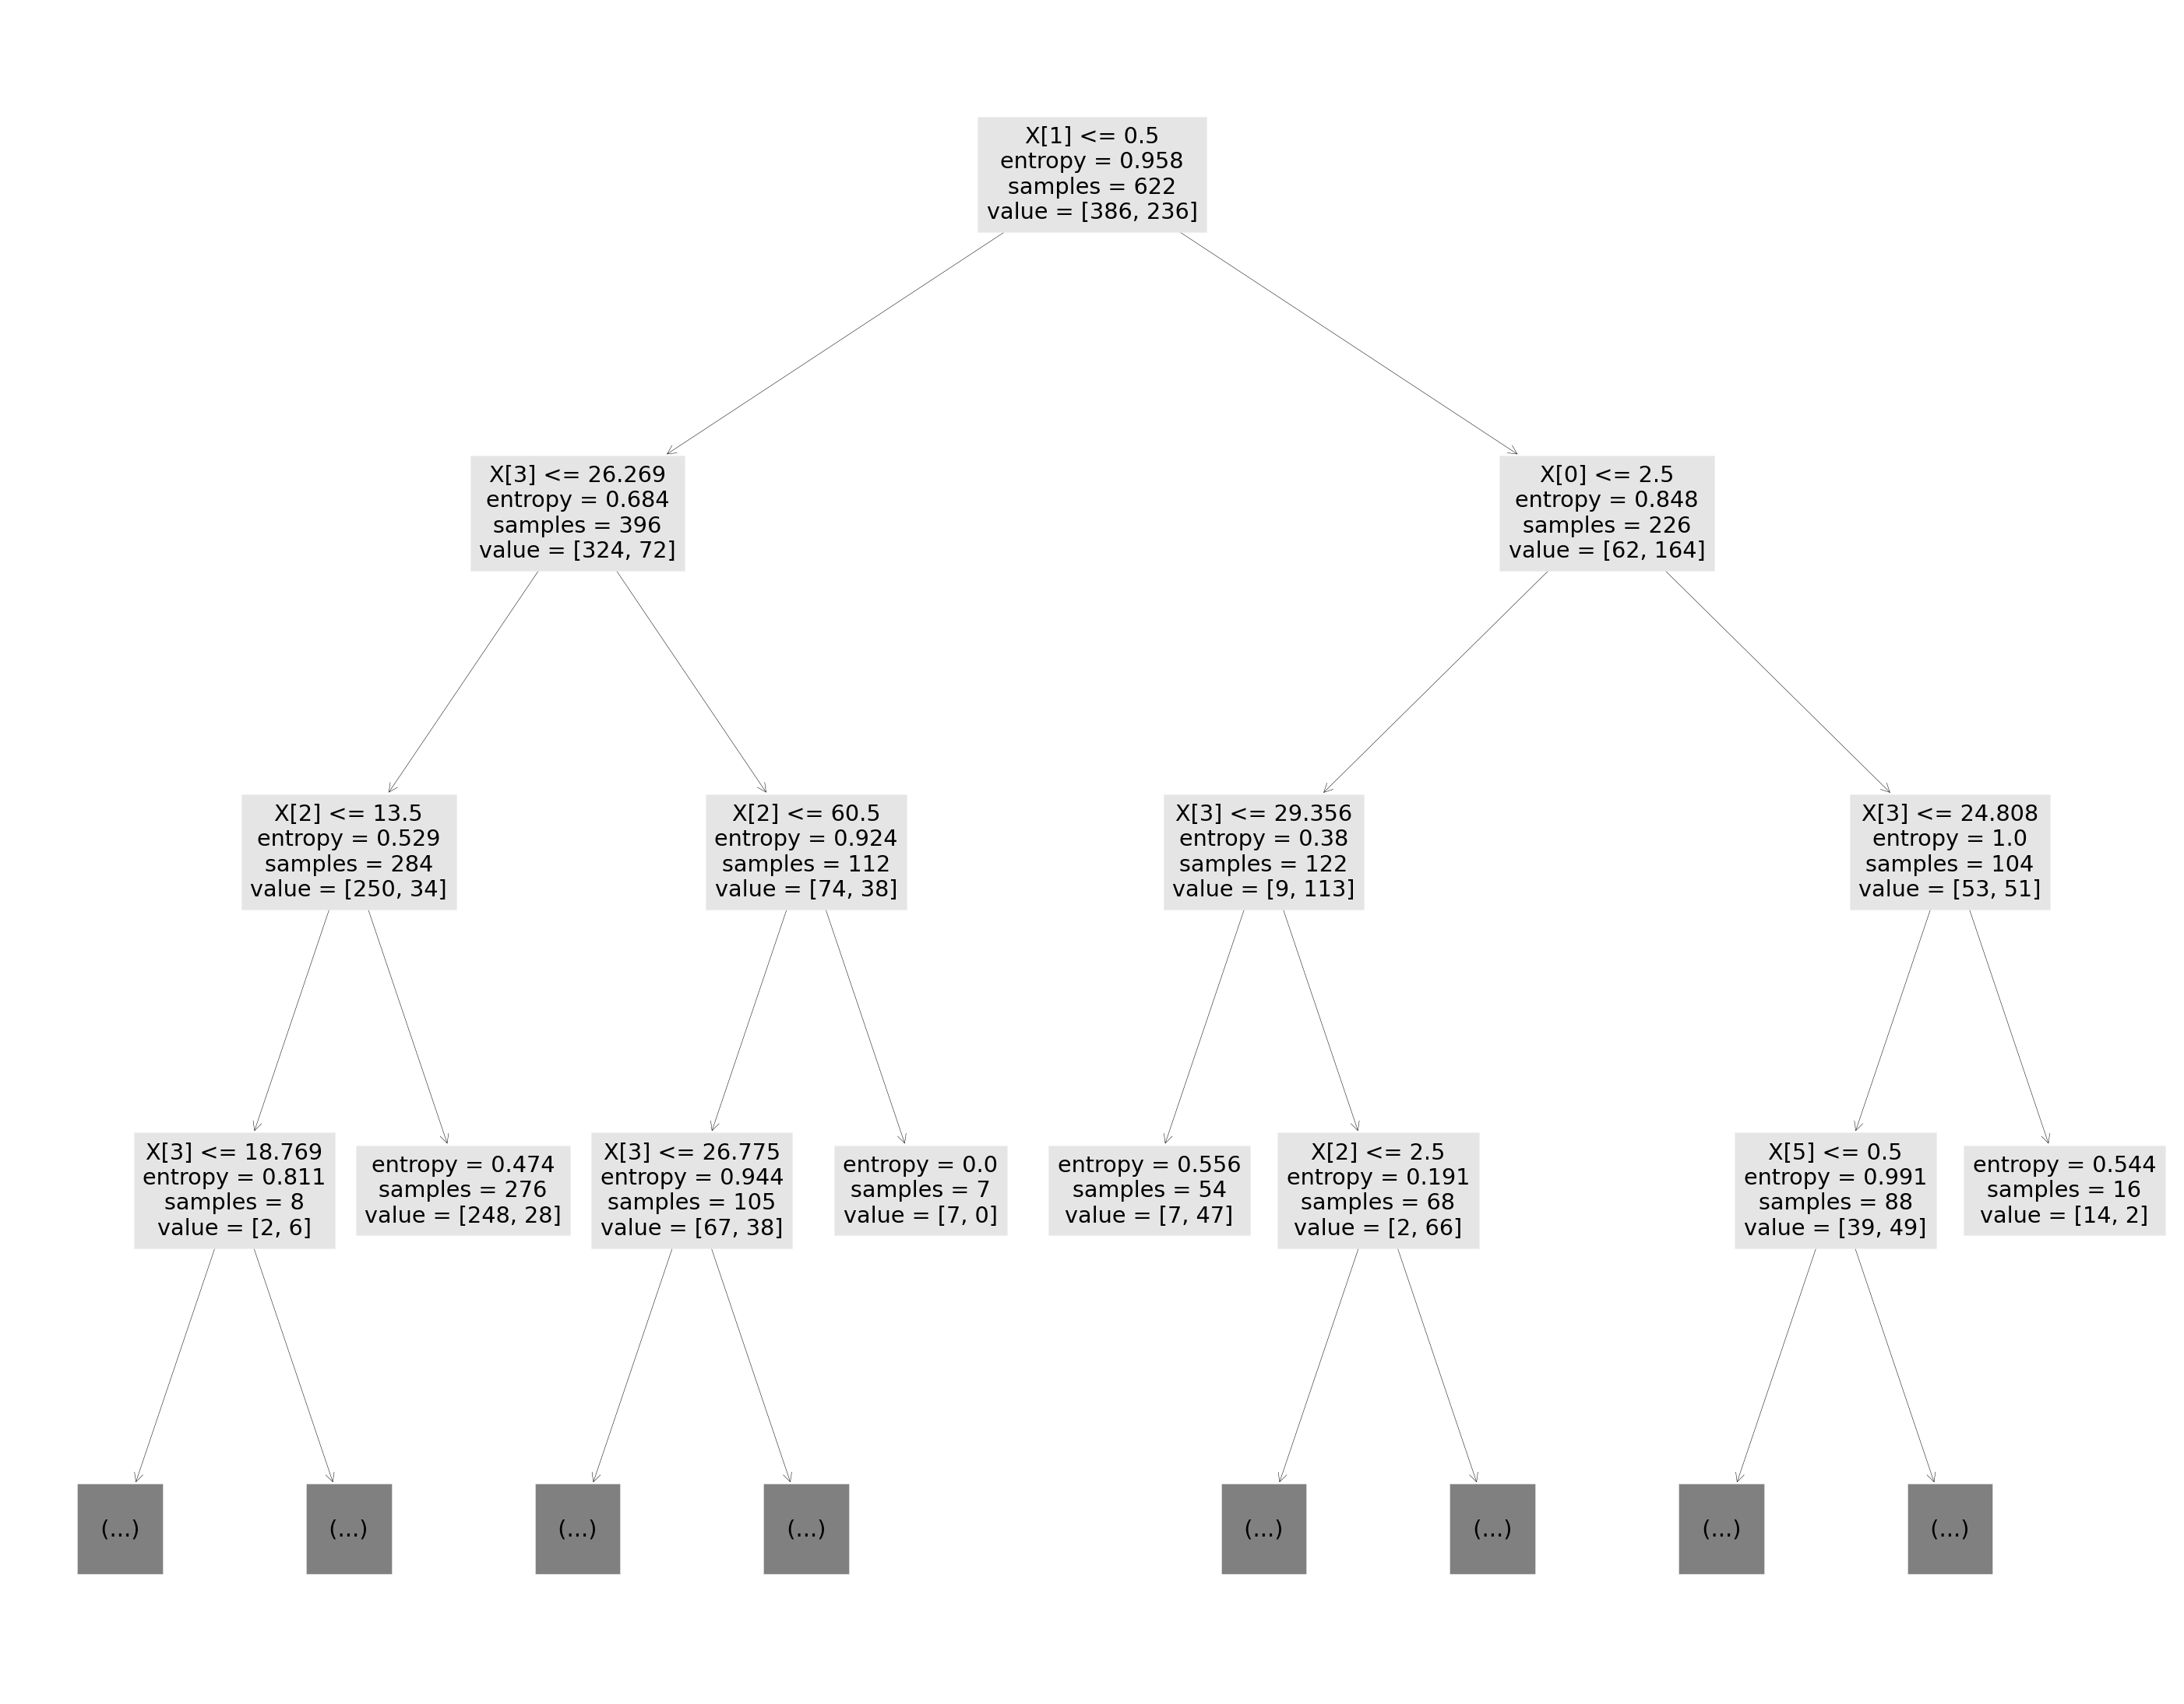

In [61]:
fig = plt.figure(figsize=(50,40))
tree.plot_tree(c50_01, max_depth=3)
plt.show()

## Random Forest

In [62]:
#Create our random forest model using max estimators 100
rf01 = RandomForestClassifier(n_estimators = 100,criterion="gini").fit(x_train,y_train)
y_pred_rf = rf01.predict(x_test)

In [63]:
print(confusion_matrix(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))
print(accuracy_score(y_test, y_pred_rf))

[[147  16]
 [ 29  75]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       163
           1       0.82      0.72      0.77       104

    accuracy                           0.83       267
   macro avg       0.83      0.81      0.82       267
weighted avg       0.83      0.83      0.83       267

0.8314606741573034


## Logistic Regression

In [64]:
#Star by importing necessary tools
from sklearn.linear_model import LogisticRegression

In [65]:
#Create logistic regression model and fit it with data from x and y training sets
log01 = LogisticRegression(solver='liblinear', random_state=0)
log01.fit(x_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [66]:
#Now, let's make some predictions
y_pred = log01.predict(x_test)

In [82]:
#Create function to plot our confusion matrix

def plot_confusion_matrix_SVM(Y_test, Y_preds):
    conf_mat = confusion_matrix(Y_test, Y_preds)
    
    #print(conf_mat)
    fig = plt.figure(figsize=(10,10))
    plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
    plt.yticks(range(2), ['Surived', 'Perished'], rotation = 20)
    plt.xticks(range(2), ['Surived', 'Perished'], rotation = 20)
    plt.title("Confusion Matrix for M")
    plt.xlabel("Predicted")
    ax.xaxis.set_label_position('top') 
    plt.ylabel("Actual")

    plt.colorbar();
    for i in range(2):
        for j in range(2):
            plt.text(i-0.2,j+0.1, str(conf_mat[j, i]), color='tab:red')
     
    #plt.show()
    plt.savefig('log_cm.png', bbox_inches = 'tight')

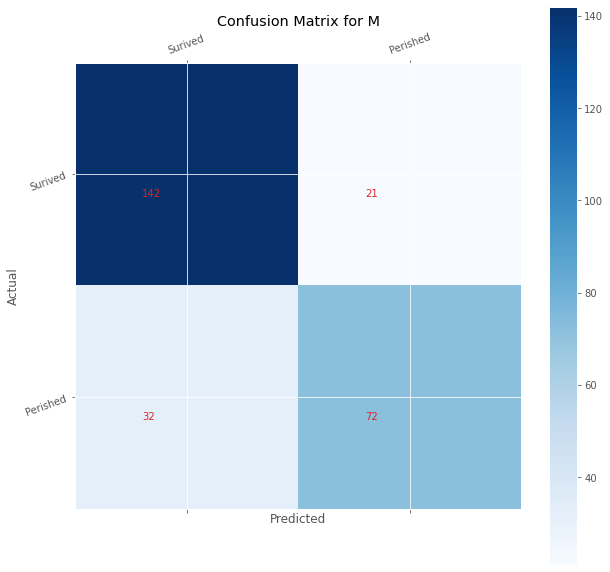

In [68]:
plot_confusion_matrix_SVM(y_test, y_pred)

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       163
           1       0.77      0.69      0.73       104

    accuracy                           0.80       267
   macro avg       0.80      0.78      0.79       267
weighted avg       0.80      0.80      0.80       267

